In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = "data/default_cc_clean_stage1.csv"
df = pd.read_csv(DATA_PATH)

# Detect target name robustly
possible_targets = ["default.payment.next.month", "default payment next month"]
TARGET_COL = None
for col in possible_targets:
    if col in df.columns:
        TARGET_COL = col
        break

if TARGET_COL is None:
    raise ValueError("Target column not found. Check CSV column names.")

print("Using target:", TARGET_COL)

Using target: default payment next month


In [3]:
cat_cols = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]

num_cols = [c for c in df.columns if c not in cat_cols + [TARGET_COL]]

X = df[cat_cols + num_cols]
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (21000, 23)
Test shape: (9000, 23)


In [4]:

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [5]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

log_reg_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg),
    ]
)

print("\nFitting Logistic Regression...")
log_reg_pipe.fit(X_train, y_train)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_clf),
    ]
)

print("Fitting Random Forest...")
rf_pipe.fit(X_train, y_train)


Fitting Logistic Regression...
Fitting Random Forest...


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [6]:
# ----------------------------------------------------------------------
# 4. FEATURE NAMES AFTER PREPROCESSING
# ----------------------------------------------------------------------

fitted_preprocessor = log_reg_pipe.named_steps["preprocess"]


num_feature_names = num_cols


ohe = fitted_preprocessor.named_transformers_["cat"]


cat_feature_names = list(ohe.get_feature_names_out(cat_cols))


all_feature_names = num_feature_names + cat_feature_names

print("\nTotal transformed feature count:", len(all_feature_names))


Total transformed feature count: 87



Top 10 features by absolute coefficient:
        feature      coef
25      PAY_0_0 -1.143232
27      PAY_0_2  1.122387
28      PAY_0_3  1.020676
23     PAY_0_-2 -0.952240
40      PAY_2_4 -0.663918
19  EDUCATION_4 -0.652402
29      PAY_0_4  0.619601
41      PAY_2_5  0.514970
24     PAY_0_-1 -0.491344
72      PAY_5_4 -0.480666
82      PAY_6_4  0.437972
63      PAY_4_5 -0.423226
79      PAY_6_0 -0.408492
81      PAY_6_3  0.354224
50      PAY_3_3  0.347759
17  EDUCATION_2  0.335909
60      PAY_4_2  0.325511
39      PAY_2_3  0.319611
16  EDUCATION_1  0.313964
37      PAY_2_1 -0.305320


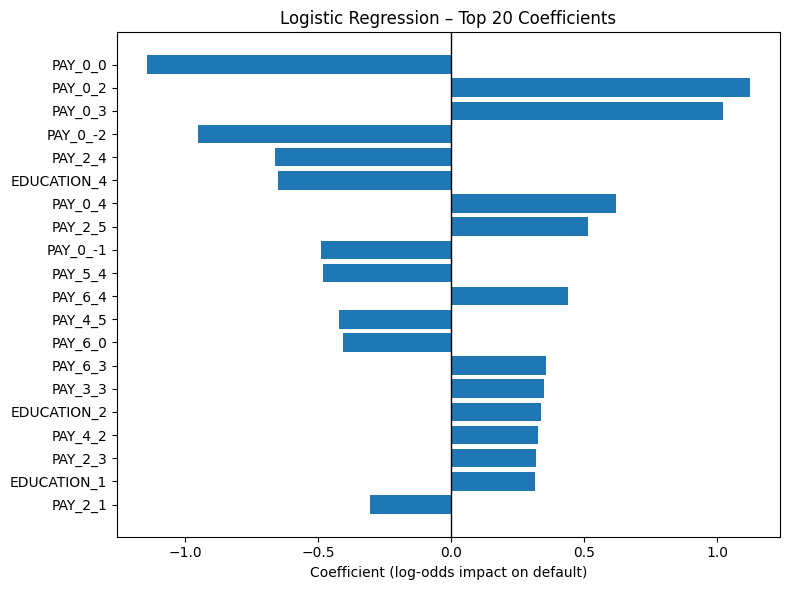

In [7]:
# ----------------------------------------------------------------------
# 5. LOGISTIC REGRESSION 
# ----------------------------------------------------------------------

log_reg_model = log_reg_pipe.named_steps["model"]
coefs = log_reg_model.coef_[0]  # shape: (n_features,)

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coefs,
})


coef_df["abs_coef"] = coef_df["coef"].abs()


top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)
top_abs = coef_df.sort_values("abs_coef", ascending=False).head(20)

print("\nTop 10 features by absolute coefficient:")
print(top_abs[["feature", "coef"]])

# top 20 by |coef|
plt.figure(figsize=(8, 6))
plt.barh(top_abs["feature"][::-1], top_abs["coef"][::-1])
plt.axvline(0, color="k", linewidth=1)
plt.title("Logistic Regression – Top 20 Coefficients")
plt.xlabel("Coefficient (log-odds impact on default)")
plt.tight_layout()
plt.show()


Top 20 features by Random Forest importance:
      feature  importance
0   LIMIT_BAL    0.057067
27    PAY_0_2    0.055413
2   BILL_AMT1    0.054673
8    PAY_AMT1    0.051822
9    PAY_AMT2    0.049533
3   BILL_AMT2    0.048894
10   PAY_AMT3    0.046813
1         AGE    0.046458
5   BILL_AMT4    0.046117
4   BILL_AMT3    0.046071
6   BILL_AMT5    0.045381
7   BILL_AMT6    0.044787
13   PAY_AMT6    0.043393
11   PAY_AMT4    0.042272
12   PAY_AMT5    0.041077
38    PAY_2_2    0.035476
25    PAY_0_0    0.029913
49    PAY_3_2    0.022701
60    PAY_4_2    0.019722
70    PAY_5_2    0.015221


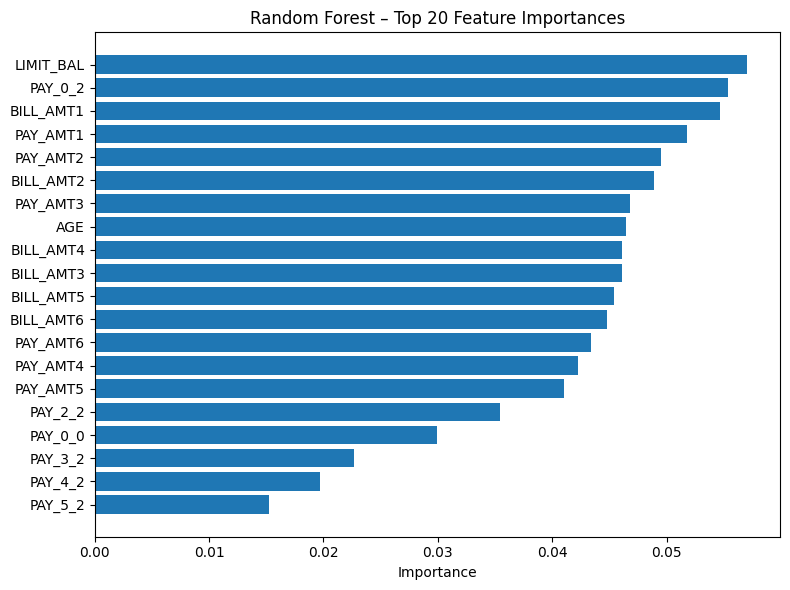

In [8]:
# ----------------------------------------------------------------------
# 6. RANDOM FOREST – FEATURE IMPORTANCES
# ----------------------------------------------------------------------

rf_model = rf_pipe.named_steps["model"]
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
})

fi_df_sorted = fi_df.sort_values("importance", ascending=False)
print("\nTop 20 features by Random Forest importance:")
print(fi_df_sorted.head(20))

plt.figure(figsize=(8, 6))
plt.barh(fi_df_sorted["feature"].head(20)[::-1], fi_df_sorted["importance"].head(20)[::-1])
plt.title("Random Forest – Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()